In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 载入数据
数据源：“Python数据科学”公众号提供的爬虫采集的链家全网北京二手房数据。

In [2]:
! ls ../dataset/lianjia

lianjia.csv


In [3]:
# 导入链家二手房数据
lianjia_df = pd.read_csv('../dataset/lianjia/lianjia.csv')
lianjia_df.head()

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year
0,东西,灯市口,NaN,6,锡拉胡同21号院,101102647043,3室1厅,780.0,东城,精装,75.0,1988
1,南北,东单,无电梯,6,东华门大街,101102650978,2室1厅,705.0,东城,精装,60.0,1988
2,南西,崇文门,有电梯,16,新世界中心,101102672743,3室1厅,1400.0,东城,其他,210.0,1996
3,南,崇文门,NaN,7,兴隆都市馨园,101102577410,1室1厅,420.0,东城,精装,39.0,2004
4,南,陶然亭,有电梯,19,中海紫御公馆,101102574696,2室2厅,998.0,东城,精装,90.0,2010


In [4]:
lianjia_df.shape

(23677, 12)

# 数据清洗

## 数据去重

In [5]:
# 存在重复数据
lianjia_df.duplicated().any()

True

In [6]:
lianjia_df[lianjia_df.duplicated()==True].shape

(1209, 12)

In [7]:
lianjia_df.drop_duplicates(inplace=True)

In [8]:
lianjia_df.duplicated().any()

False

In [9]:
lianjia_df.shape

(22468, 12)

## Index调整
Id 特征对我们的分析没有什么实际意义，移除。

房屋单价分析起来比较方便，简单的使用总价/面积就可得到，所以增加一列 PerPrice。

In [10]:
# 添加单价列
df = lianjia_df.copy()
df['PerPrice'] = lianjia_df['Price']/lianjia_df['Size']

# 调整列的顺序，去掉Id
columns = ['Region', 'District', 'Garden', 'Layout', 'Floor', 'Year', 'Size', 'Elevator', 'Direction', 'Renovation', 'PerPrice', 'Price']
df = pd.DataFrame(df, columns = columns)

# 调整后
df.head()

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,NaN,东西,精装,10.400000,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.750000,705.0
2,东城,崇文门,新世界中心,3室1厅,16,1996,210.0,有电梯,南西,其他,6.666667,1400.0
3,东城,崇文门,兴隆都市馨园,1室1厅,7,2004,39.0,NaN,南,精装,10.769231,420.0
4,东城,陶然亭,中海紫御公馆,2室2厅,19,2010,90.0,有电梯,南,精装,11.088889,998.0


## 异常值处理

In [11]:
# 缺失值情况概览
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22468 entries, 0 to 23676
Data columns (total 12 columns):
Region        22468 non-null object
District      22468 non-null object
Garden        22468 non-null object
Layout        22468 non-null object
Floor         22468 non-null int64
Year          22468 non-null int64
Size          22468 non-null float64
Elevator      14569 non-null object
Direction     22468 non-null object
Renovation    22468 non-null object
PerPrice      22468 non-null float64
Price         22468 non-null float64
dtypes: float64(3), int64(2), object(7)
memory usage: 2.2+ MB


数据集一共有23677条数据，其中Elevator特征有明显的缺失值。
通过value_counts可以看到，有数据的也有大概20条无意义，该数据项问题较大。

In [12]:
df.Elevator.value_counts()

有电梯    8799
无电梯    5750
精装       11
毛坯        7
简装        2
Name: Elevator, dtype: int64

In [13]:
# 通过describe粗略观察数据特征
df.describe()

,Floor,Year,Size,PerPrice,Price
count,22468.000000,22468.000000,22468.000000,22468.000000,22468.000000
mean,12.719512,2001.372085,99.204736,6.637498,608.365849
std,7.625692,9.040650,51.465747,13.739231,412.399905
min,1.000000,1950.000000,2.000000,1.223404,60.000000
25%,6.000000,1997.000000,66.000000,4.246526,360.000000
50%,11.000000,2003.000000,88.000000,5.529412,495.000000
75%,18.000000,2008.000000,118.000000,7.991997,710.000000
max,57.000000,2017.000000,1019.000000,1000.000000,6000.000000


观察Size(面积)列：最小值为2平米，这明显不符合直观感受，数据可能存在问题；观察四分位数，应该是存在一个较大的误差值把数据往右拉了。

In [14]:
# 查看面积比较小的几条数据的情况
df[df.Size < 20]

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
134,昌平,沙河,北街家园七区,1室1厅,17,2010,19.0,有电梯,西,简装,9.473684,180.0
1168,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,240.97平米,南北,216.000000,1080.0
1458,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,242.78平米,南北,220.000000,1100.0
1797,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,精装,242.96平米,南北,196.000000,980.0
2268,顺义,顺义其它,龙湖好望山,叠拼别墅,4,2014,4.0,精装,295.88平米,南北,250.000000,1000.0
2274,顺义,顺义其它,鹭峯国际,叠拼别墅,4,2014,5.0,精装,295.01平米,南北,290.000000,1450.0
2276,顺义,顺义其它,龙湖好望山,叠拼别墅,3,2014,4.0,毛坯,292.31平米,南北,215.000000,860.0
2432,顺义,顺义其它,龙湖好望山,叠拼别墅,5,2013,6.0,精装,294.42平米,南北,163.333333,980.0
4078,大兴,西红门,鸿坤林语墅,叠拼别墅,3,2015,4.0,精装,427.5平米,南北,787.500000,3150.0
4079,大兴,西红门,鸿坤林语墅,叠拼别墅,4,2015,4.0,精装,361.8平米,南北,595.000000,2380.0


In [15]:
df[df.Layout == '叠拼别墅']

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
1168,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,240.97平米,南北,216.000000,1080.0
1458,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,242.78平米,南北,220.000000,1100.0
1797,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,精装,242.96平米,南北,196.000000,980.0
2268,顺义,顺义其它,龙湖好望山,叠拼别墅,4,2014,4.0,精装,295.88平米,南北,250.000000,1000.0
2274,顺义,顺义其它,鹭峯国际,叠拼别墅,4,2014,5.0,精装,295.01平米,南北,290.000000,1450.0
2276,顺义,顺义其它,龙湖好望山,叠拼别墅,3,2014,4.0,毛坯,292.31平米,南北,215.000000,860.0
2432,顺义,顺义其它,龙湖好望山,叠拼别墅,5,2013,6.0,精装,294.42平米,南北,163.333333,980.0
4078,大兴,西红门,鸿坤林语墅,叠拼别墅,3,2015,4.0,精装,427.5平米,南北,787.500000,3150.0
4079,大兴,西红门,鸿坤林语墅,叠拼别墅,4,2015,4.0,精装,361.8平米,南北,595.000000,2380.0
4761,大兴,西红门,鸿坤林语墅,叠拼别墅,3,2015,5.0,精装,386.83平米,南北,540.000000,2700.0


别墅的数据类型可能与一般房源不同，导致爬虫拿到的数据发生错位。另外别墅类型二手房与其他数据差别IE较大，不在考虑范围之内，可以直接移除。

In [16]:
df.drop(df[df.Layout == '叠拼别墅'].index, inplace=True)

In [17]:
# 再看面积较大的几个情况
df.loc[df['Size']>500]

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
196,怀柔,怀柔,龙山新新小镇六期,5室3厅,2,2008,585.0,NaN,南北,精装,3.589744,2100.0
284,门头沟,冯村,华润西山墅,5室4厅,3,2013,656.0,有电梯,南北,精装,4.420732,2900.0
294,门头沟,冯村,华润西山墅,4室3厅,5,2013,541.0,有电梯,南北,精装,4.066543,2200.0
2305,顺义,马坡,富力湾,8室3厅,3,2010,705.0,NaN,东南西北,毛坯,3.546099,2500.0
2325,顺义,中央别墅区,丽斯花园,8室2厅,2,2000,508.0,NaN,东南西北,简装,7.874016,4000.0
2345,顺义,顺义其它,蓝岸丽舍二期,5室3厅,2,2012,508.0,NaN,南北,精装,3.110236,1580.0
2417,顺义,中央别墅区,丽嘉花园,4室2厅,2,2007,548.0,NaN,东南西北,其他,8.211679,4500.0
2491,顺义,后沙峪,中粮祥云国际生活区,5室2厅,3,2012,551.0,有电梯,南北,毛坯,4.355717,2400.0
2530,顺义,马坡,富力湾,6室3厅,3,2011,543.0,NaN,东南西北,精装,4.530387,2460.0
2832,顺义,中央别墅区,誉天下,5室3厅,3,2013,573.0,NaN,南北,毛坯,5.584642,3200.0


In [18]:
# 其中明显的面积>500 布局却是“1房间0卫”的两个房子可能是商用房，需要排除。
df.drop([8754,22164], inplace=True)

In [19]:
df.describe()

,Floor,Year,Size,PerPrice,Price
count,22446.000000,22446.000000,22446.000000,22446.000000,22446.000000
mean,12.727390,2001.362960,99.215049,6.303452,607.217941
std,7.625148,9.036837,50.804778,2.727590,409.403152
min,1.000000,1950.000000,15.000000,1.223404,60.000000
25%,6.000000,1997.000000,66.000000,4.245283,360.000000
50%,11.000000,2003.000000,88.000000,5.526316,495.000000
75%,18.000000,2008.000000,118.000000,7.978723,710.000000
max,57.000000,2017.000000,855.000000,16.250000,6000.000000


In [20]:
# 查看楼层是否存在偏差值
df[df.Floor > 40]

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
18563,朝阳,东大桥,北京财富中心,3室2厅,42,2005,202.0,NaN,南西北,精装,8.415842,1700.0
18679,朝阳,东大桥,御金台,3室1厅,57,2008,251.0,有电梯,北,精装,11.952191,3000.0


In [21]:
df.shape

(22446, 12)

# 可视化分析
## Region(行政区)特征分析

In [22]:
plt.style.use("ggplot")
sns.set_style({'font.sans-serif':['simhei']})
%matplotlib inline

In [23]:
# 二手房单价均值在各行政区的分布
df_house_mean = df.groupby('Region')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
df_house_mean

,Region,PerPrice
0,西城,10.680735
1,东城,9.878085
2,海淀,8.590684
3,朝阳,7.014069
4,丰台,5.763195
5,石景山,5.539351
6,亦庄开发区,4.697127
7,大兴,4.516423
8,通州,4.482234
9,昌平,4.301291


In [24]:
# 二手房总数在各行政区的分布
df_house_count = df.groupby('Region')['Price'].count().sort_values(ascending=False).to_frame().reset_index()
df_house_count = df_house_count.rename(columns={'Region':'行政区','Price':'数量'})
df_house_count

,行政区,数量
0,丰台,2756
1,海淀,2724
2,朝阳,2672
3,昌平,2659
4,西城,2059
5,大兴,2025
6,通州,1563
7,东城,1484
8,房山,1408
9,顺义,1197


In [25]:
df_house_count['占比'] = df_house_count['数量']/df_house_count.sum()['数量']
df_house_count

,行政区,数量,占比
0,丰台,2756,0.122784
1,海淀,2724,0.121358
2,朝阳,2672,0.119041
3,昌平,2659,0.118462
4,西城,2059,0.091731
5,大兴,2025,0.090217
6,通州,1563,0.069634
7,东城,1484,0.066114
8,房山,1408,0.062728
9,顺义,1197,0.053328


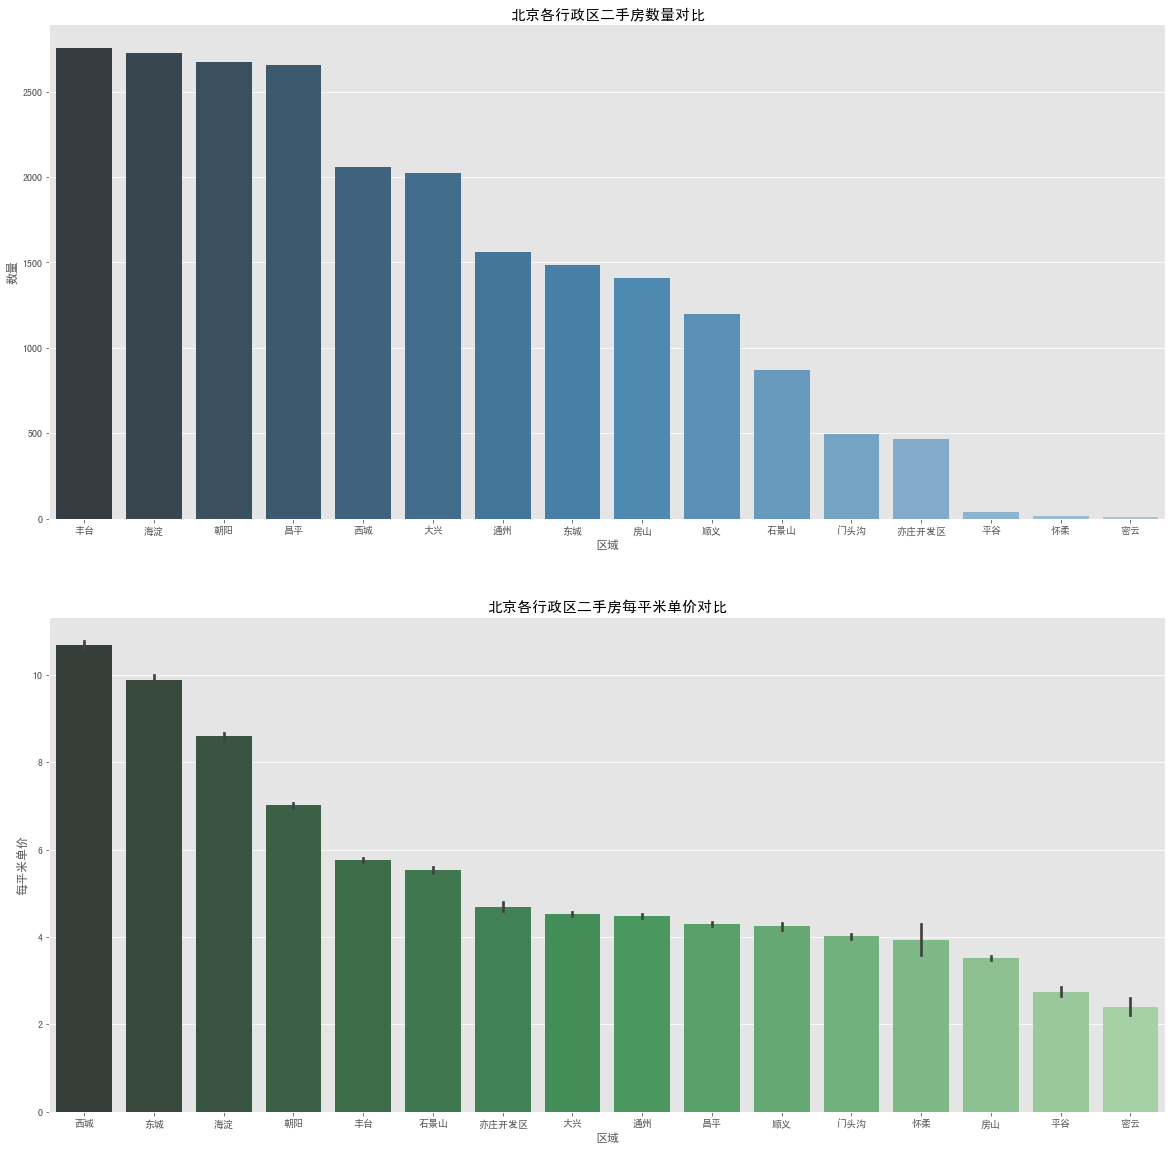

In [26]:
# 可视化分析
f, axes = plt.subplots(2,1,figsize=(20,20))

sns.barplot(x='行政区', y='数量', palette="Blues_d", data=df_house_count, ax=axes[0])
axes[0].set_title('北京各行政区二手房数量对比',fontsize=15)
axes[0].set_xlabel('区域')
axes[0].set_ylabel('数量')

sns.barplot(x='Region', y='PerPrice', palette="Greens_d", data=df, ax=axes[1], order=list(df_house_mean['Region']))
axes[1].set_title('北京各行政区二手房每平米单价对比',fontsize=15)
axes[1].set_xlabel('区域')
axes[1].set_ylabel('每平米单价')

plt.show()
f.savefig('chart/Region.png', bbox_inches='tight')

## Size(面积)特征分析

In [27]:
size_bins = np.array([0,20,40,60,80,100,120,150,200,500,1000])
labels = pd.cut(df.Size, size_bins)
labels

0          (60, 80]
1          (40, 60]
2        (200, 500]
3          (20, 40]
4         (80, 100]
            ...    
23672     (80, 100]
23673      (60, 80]
23674    (150, 200]
23675    (100, 120]
23676     (80, 100]
Name: Size, Length: 22446, dtype: category
Categories (10, interval[int64]): [(0, 20] < (20, 40] < (40, 60] < (60, 80] ... (120, 150] < (150, 200] < (200, 500] < (500, 1000]]

In [28]:
size_bins_series = df.groupby(labels).size()
size_bins_series = size_bins_series/size_bins_series.sum() * 100
size_bins_series

Size
(0, 20]         0.035641
(20, 40]        1.790965
(40, 60]       16.800321
(60, 80]       21.714337
(80, 100]      24.137931
(100, 120]     12.073421
(120, 150]     12.233806
(150, 200]      7.079212
(200, 500]      4.040809
(500, 1000]     0.093558
dtype: float64

In [29]:
color_org = sns.color_palette('Blues')[4]

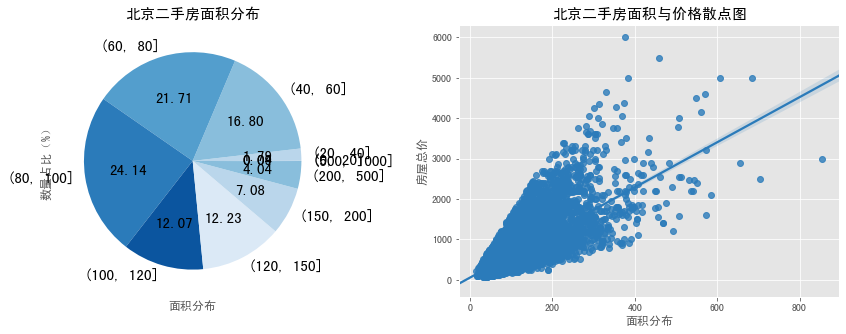

In [30]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
# 房屋面积的分布情况
# df.groupby(labels).size().plot.bar(ax=axes[0])
size_bins_series.plot.pie(ax=axes[0], colors=sns.color_palette('Blues'), autopct='%.2f', fontsize=15)
axes[0].set_title('北京二手房面积分布',fontsize=15)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)
axes[0].set_xlabel('面积分布')
axes[0].set_ylabel('数量占比（%）')


# 房屋面积和出售价格的关系
sns.regplot(x='Size', y='Price', data=df, ax=axes[1], color= color_org)
axes[1].set_title('北京二手房面积与价格散点图',fontsize=15)
axes[1].set_xlabel('面积分布')
axes[1].set_ylabel('房屋总价')

plt.show()
f.savefig('chart/Size.png', bbox_inches='tight')

## Layout(户型)特征分析

In [31]:
layout_df = df.Layout.value_counts()
layout_df

2室1厅      8955
3室1厅      3792
3室2厅      2614
1室1厅      2569
2室2厅      1558
4室2厅       899
1室0厅       480
4室1厅       282
5室2厅       191
2房间1卫      169
1房间1卫      144
3房间1卫      116
4室3厅        95
5室3厅        74
1室2厅        62
6室2厅        57
3房间2卫       53
2室0厅        47
3室3厅        43
4房间2卫       31
6室3厅        29
5室1厅        26
3室0厅        25
2房间2卫       18
4房间1卫       15
1房间0卫       12
5房间2卫       10
4房间3卫        7
5房间3卫        6
7室3厅         6
7室2厅         5
2室3厅         5
5室4厅         4
4室4厅         4
8室3厅         4
6室4厅         4
6房间4卫        3
4室0厅         3
8室2厅         3
1房间2卫        2
3房间3卫        2
3房间0卫        2
2房间0卫        2
6房间3卫        2
6室0厅         2
6房间5卫        1
9室3厅         1
6室5厅         1
5室0厅         1
9室1厅         1
8室5厅         1
6室1厅         1
1室3厅         1
5房间0卫        1
7室1厅         1
11房间3卫       1
8室4厅         1
9室2厅         1
7房间2卫        1
Name: Layout, dtype: int64

In [32]:
layout_df.shape

(59,)

户型类型太多，而且不规范，在描述上没有统一标准。比如有的统计了卫生间情况，有的则没有包含这部分内容。

如果要使用此特征做预测，还需要进行处理，可以将该特征拆开成3个特征：房间数量，客厅数量，卫生间数量。

In [33]:
# 归一化
layout_df = layout_df/layout_df.sum()
layout_cumsum = layout_df.cumsum()

In [34]:
# 户型类型太多，我们选取其中占比较大的一部分看分布，其他占比较小的部分标记为‘其他’
layout_95_index = layout_cumsum.searchsorted(0.95)
layout_pie_df = layout_df[:layout_95_index]
layout_pie_df['其他'] = 1 - layout_pie_df.sum()
layout_pie_df

2室1厅    0.398957
3室1厅    0.168939
3室2厅    0.116457
1室1厅    0.114452
2室2厅    0.069411
4室2厅    0.040052
1室0厅    0.021385
4室1厅    0.012563
其他      0.057783
Name: Layout, dtype: float64

In [35]:
layout_mapping = {}.fromkeys(layout_df[layout_95_index:].index, '其他')

In [36]:
df.Layout = df.Layout.map(lambda x:layout_mapping.get(x, x))

In [37]:
df.Layout.value_counts()

2室1厅    8955
3室1厅    3792
3室2厅    2614
1室1厅    2569
2室2厅    1558
其他      1297
4室2厅     899
1室0厅     480
4室1厅     282
Name: Layout, dtype: int64

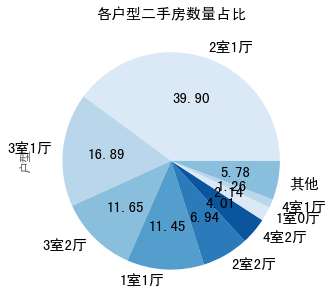

In [38]:
f, axes= plt.subplots(1, figsize=(20,5))

layout_pie_df.plot.pie(autopct='%.2f',ax=axes, colors=sns.color_palette('Blues'),fontsize=15)
axes.set_title('各户型二手房数量占比',fontsize=15)
axes.set_ylabel('户型')

# sns.barplot(x='Layout', y='PerPrice',  data=df, ax=axes[1], order=list(layout_pie_df.index), palette="Blues")
# axes[1].set_title('各户型二手房单价对比', fontsize=15)
# axes[1].set_xlabel('户型')
# axes[1].set_ylabel('每平米单价')

plt.show()
f.savefig('chart/Layout.png', bbox_inches='tight')

## Direction(朝向)特征分析

In [39]:
direction_df = df.Direction.value_counts()
direction_df

南北        10861
南          2696
东西         1329
东南         1253
西南         1047
东           908
西           835
西北          719
东北          634
北           585
东南北         435
南西北         356
南西          152
东西北         134
东南西         126
西南北         118
东南西北         85
西南东北         22
南东北          18
东南南          14
东南西南         13
西南西北         10
东东南          10
西东北           9
南西南           9
东南东北          8
东西南           8
西南西           6
东南南北          5
南西东北          3
西北东北          2
南西北北          2
东西南北          2
东东北           2
南东            2
西西南           2
南西南西          2
南西南北          2
西西北           2
东南西北北         1
西南西北北         1
北南            1
东西东北          1
西南西北东北        1
南北东北          1
东南西南北         1
北西            1
东东南南          1
东南西北东北        1
东南南西北         1
东北东北          1
东西北北          1
东南西南东北        1
南西西北          1
东西北东北         1
南北西           1
西北北           1
东南北西          1
南北东           1
Name: Direction, dtype: int64

In [40]:
direction_df.shape

(59,)

In [41]:
# 归一化
direction_df = direction_df/direction_df.sum()
# 朝向类型太多，我们选取其中占比达到95%的部分数据，其他占比较小的部分标记为‘其他’
direction_cumsum = direction_df.cumsum()
direction_95_index = direction_cumsum.searchsorted(0.95)
direction_pie_df = direction_df[:direction_95_index]
direction_pie_df['其他'] = 1 - direction_pie_df.sum()
direction_pie_df

南北     0.483872
南      0.120110
东西     0.059209
东南     0.055823
西南     0.046645
东      0.040453
西      0.037200
西北     0.032032
东北     0.028246
北      0.026063
东南北    0.019380
其他     0.050967
Name: Direction, dtype: float64

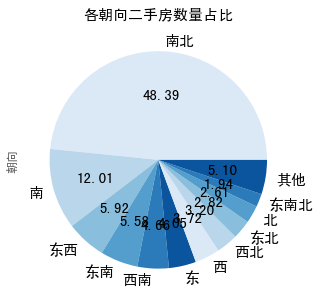

In [42]:
f, axes= plt.subplots(1,figsize=(20,5))

# direction_pie_df.plot.barh(ax=axes[0], color=sns.color_palette('Blues'),fontsize=15)
# axes[0].set_title('各朝向二手房数量占比',fontsize=15)
# axes[0].set_xlabel('二手房数量（%）')
# axes[0].set_ylabel('朝向')

direction_pie_df.plot.pie(autopct='%.2f',ax=axes, colors=sns.color_palette('Blues'),fontsize=15)
axes.set_title('各朝向二手房数量占比',fontsize=15)
axes.set_ylabel('朝向')

plt.show()
f.savefig('chart/Direction.png', bbox_inches='tight')

In [43]:
direction_mapping = {}.fromkeys(direction_df[direction_95_index : ].index, '其他') 
df.Direction = df.Direction.map(lambda x:direction_mapping.get(x, x))

In [44]:
df.Direction.value_counts()

南北     10861
南       2696
东西      1329
东南      1253
其他      1144
西南      1047
东        908
西        835
西北       719
东北       634
北        585
东南北      435
Name: Direction, dtype: int64

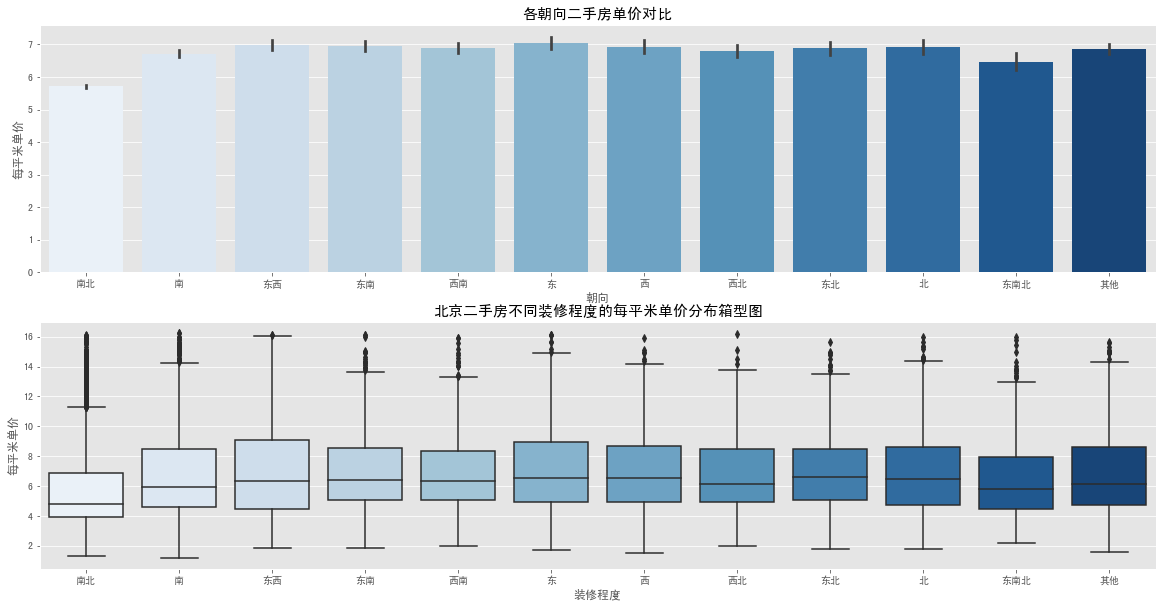

In [45]:
f, axes= plt.subplots(2,1, figsize=(20,10))

sns.barplot(x='Direction', y='PerPrice',  data=df, ax=axes[0], order=list(direction_pie_df.index), palette="Blues")
axes[0].set_title('各朝向二手房单价对比', fontsize=15)
axes[0].set_xlabel('朝向')
axes[0].set_ylabel('每平米单价')

sns.boxplot(x='Direction', y='PerPrice', data=df, ax=axes[1], order=list(direction_pie_df.index), palette='Blues')
axes[1].set_title('北京二手房不同装修程度的每平米单价分布箱型图',fontsize=15)
axes[1].set_xlabel('装修程度')
axes[1].set_ylabel('每平米单价')
 
f.savefig('chart/Simpsons_paradox.png', bbox_inches='tight')

In [46]:
df.pivot_table('PerPrice', index='Region',columns='Direction', aggfunc='mean')

Direction,东,东北,东南,东南北,东西,其他,北,南,南北,西,西北,西南
Region,,,,,,,,,,,,
东城,9.505398,9.256276,9.546500,10.155940,9.983433,10.149046,9.604450,10.492325,10.126005,9.354708,9.336255,9.272113
丰台,5.749223,5.832658,5.718181,6.052859,5.484109,5.772244,6.194562,5.920631,5.734204,5.679242,5.535356,5.765217
亦庄开发区,3.948090,4.751326,4.001447,5.485368,4.585752,4.517111,3.957982,4.496193,5.063408,4.189172,3.933164,4.439385
大兴,4.466197,4.279257,4.694473,4.615648,4.338169,4.712206,3.978924,4.753409,4.468393,4.649280,4.801327,5.044513
密云,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.336202,NaN,3.013514,NaN
平谷,NaN,2.970149,NaN,NaN,NaN,2.567164,NaN,2.887086,2.735679,NaN,3.134328,NaN
怀柔,NaN,3.859649,NaN,3.745928,NaN,NaN,NaN,NaN,3.954715,NaN,NaN,NaN
房山,2.829380,3.233170,3.194011,3.709277,3.118297,3.350232,3.305165,3.817195,3.543508,2.860661,3.348598,3.204581
昌平,4.378704,4.330005,4.507563,4.426602,4.070150,4.298876,4.956459,4.777028,4.203078,4.456138,4.287807,4.444951


In [47]:
df.pivot_table('PerPrice', index='Region',columns='Direction', aggfunc='count')

Direction,东,东北,东南,东南北,东西,其他,北,南,南北,西,西北,西南
Region,,,,,,,,,,,,
东城,132.0,60.0,85.0,26.0,176.0,94.0,69.0,183.0,415.0,126.0,70.0,48.0
丰台,137.0,129.0,247.0,61.0,146.0,173.0,89.0,355.0,894.0,149.0,135.0,241.0
亦庄开发区,19.0,14.0,17.0,2.0,25.0,11.0,32.0,53.0,241.0,25.0,11.0,17.0
大兴,41.0,24.0,45.0,43.0,116.0,70.0,16.0,181.0,1384.0,33.0,32.0,40.0
密云,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,1.0,NaN
平谷,NaN,1.0,NaN,NaN,NaN,3.0,NaN,3.0,33.0,NaN,1.0,NaN
怀柔,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN
房山,35.0,20.0,31.0,25.0,28.0,47.0,18.0,178.0,964.0,22.0,21.0,19.0
昌平,47.0,29.0,90.0,52.0,114.0,108.0,55.0,246.0,1771.0,52.0,24.0,71.0


奇怪的是南北朝向明明是数量最大的房源，按理说应该也是最受欢迎的户型，为什么平均价格这么低呢？我以为是波动很大，结果看起来波动还挺小的。

没有去掉空值，这些比较偏远的区只有南北朝向的房子（也说明了确实很受欢迎），计算整体均值的时候拉低了，而其他户型没有这种房子，反而没有受影响。

也说明了直接按照朝向对比单价是没有意义的，影响因素也会很多。

## Renovation(装修)特征分析

In [48]:
df.Renovation.value_counts(dropna=False)

精装    10726
简装     8076
其他     3080
毛坯      564
Name: Renovation, dtype: int64

In [49]:
renovation_pie = df.Renovation.value_counts()

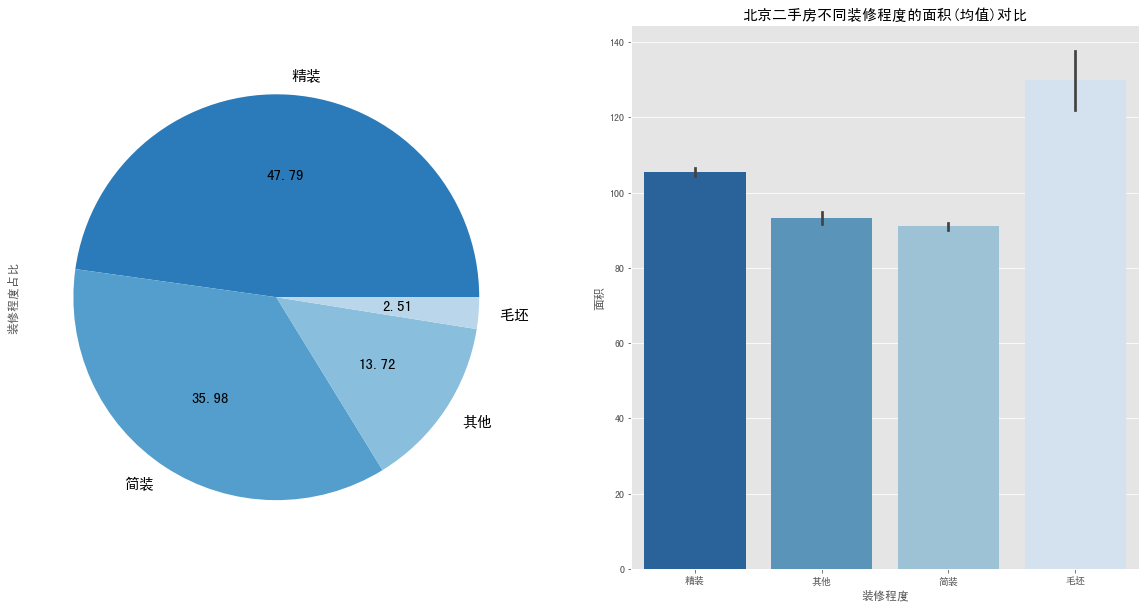

In [50]:
f, axes = plt.subplots(1, 2, figsize=(20, 10))

renovation_pie.plot.pie(ax=axes[0], colors=sns.color_palette('Blues_r')[1:],autopct='%.2f', fontsize=15)
axes[0].set_ylabel('装修程度占比')

# sns.countplot(df['Renovation'], ax=axes[0], palette='Blues_r')
# axes[0].set_title('北京二手房不同装修程度的数量对比',fontsize=15)
# axes[0].set_xlabel('装修程度')
# axes[0].set_ylabel('数量')

# sns.barplot(x='Renovation', y='Price', data=df, ax=axes[1], palette='Blues_r')
# axes[1].set_title('北京二手房不同装修程度的总价对比',fontsize=15)
# axes[1].set_xlabel('装修程度')
# axes[1].set_ylabel('总价')

# sns.barplot(x='Renovation', y='PerPrice', data=df, ax=axes[1])
# axes[1].set_title('北京二手房不同装修程度的每平米单价(均值)对比',fontsize=15)
# axes[1].set_xlabel('装修程度')
# axes[1].set_ylabel('每平米单价')

# sns.boxplot(x='Renovation', y='PerPrice', data=df, ax=axes[2], palette='Blues_r')
# axes[2].set_title('北京二手房不同装修程度的每平米单价分布箱型图',fontsize=15)
# axes[2].set_xlabel('装修程度')
# axes[2].set_ylabel('每平米单价')

sns.barplot(x='Renovation', y='Size', data=df, ax=axes[1], palette='Blues_r')
axes[1].set_title('北京二手房不同装修程度的面积(均值)对比',fontsize=15)
axes[1].set_xlabel('装修程度')
axes[1].set_ylabel('面积')

# sns.boxplot(x='Renovation', y='Size', data=df, ax=axes[4])
# axes[4].set_title('北京二手房不同装修程度的面积分布箱型图',fontsize=15)
# axes[4].set_xlabel('装修程度')
# axes[4].set_ylabel('面积')

plt.show()
f.savefig('chart/Renovation.png', bbox_inches='tight')

## Elevator(电梯)特征分析

In [51]:
# 统计缺失值情况
df.Elevator.value_counts(dropna=False)

有电梯    8798
NaN    7899
无电梯    5749
Name: Elevator, dtype: int64

如果想全面的补全，可能需要根据现有小区的电梯情况填充同样的小区，获取在网上查询电梯情况。这里，我们先把缺失的电梯特征标记为“未知”，看下这部分数据是否在两组中是均匀分布的。

In [52]:
df.fillna(value={'Elevator':'未知'}, inplace=True)

In [53]:
elevator_pie = df.Elevator.value_counts()
elevator_pie

有电梯    8798
未知     7899
无电梯    5749
Name: Elevator, dtype: int64

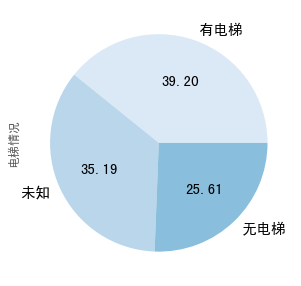

In [54]:
f, axes = plt.subplots( 1, figsize=(20, 5))

elevator_pie.plot.pie(ax=axes, colors=sns.color_palette('Blues'), autopct='%.2f', fontsize=15)
axes.set_ylabel('电梯情况')

# sns.countplot(elevator_df['Elevator'], ax=axes[0], palette='Blues_r')
# axes[0].set_title('有无电梯数量对比',fontsize=15)
# axes[0].set_xlabel('是否有电梯')
# axes[0].set_ylabel('数量')

# sns.barplot(x='Elevator', y='Price', data=elevator_df, ax=axes[1], palette='Blues_r')
# axes[1].set_title('有无电梯房屋总价对比',fontsize=15)
# axes[1].set_xlabel('是否有电梯')
# axes[1].set_ylabel('总价')

# sns.barplot(x='Elevator', y='PerPrice', data=elevator_df, ax=axes[2], palette='Blues_r')
# axes[2].set_title('有无电梯每平米单价对比',fontsize=15)
# axes[2].set_xlabel('是否有电梯')
# axes[2].set_ylabel('每平米单价')

plt.show()
f.savefig('chart/Elevator.png', bbox_inches='tight')

## Year 特征分析
### 年代分布

In [55]:
df.Year.min(), df.Year.max()

(1950, 2017)

In [56]:
year_bins = np.array([1950,1960,1970,1980,1990,2000,2010,2017])
labels = pd.cut(df.Year, year_bins)
labels

0        (1980, 1990]
1        (1980, 1990]
2        (1990, 2000]
3        (2000, 2010]
4        (2000, 2010]
             ...     
23672    (2000, 2010]
23673    (1990, 2000]
23674    (1990, 2000]
23675    (1980, 1990]
23676    (2000, 2010]
Name: Year, Length: 22446, dtype: category
Categories (7, interval[int64]): [(1950, 1960] < (1960, 1970] < (1970, 1980] < (1980, 1990] < (1990, 2000] < (2000, 2010] < (2010, 2017]]

In [57]:
year_bins_series = df.groupby(labels).size()
# year_bins_series = year_bins_series/year_bins_series.sum() * 100
year_bins_series

Year
(1950, 1960]       79
(1960, 1970]       81
(1970, 1980]      453
(1980, 1990]     2248
(1990, 2000]     5575
(2000, 2010]    10944
(2010, 2017]     3054
dtype: int64

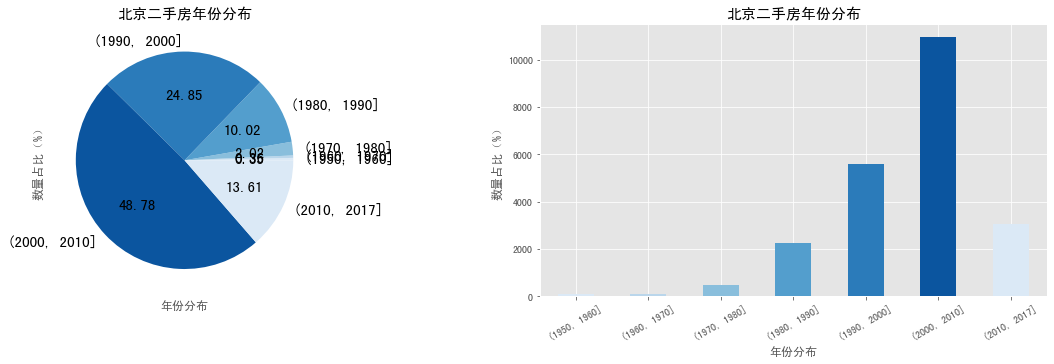

In [58]:
f, axes = plt.subplots(1,2,  figsize=(20, 5))

# df.groupby(labels).size().plot.bar(ax=axes[0])
year_bins_series.plot.pie(ax=axes[0], colors=sns.color_palette('Blues'), autopct='%.2f', fontsize=15)
axes[0].set_title('北京二手房年份分布',fontsize=15)
axes[0].set_xlabel('年份分布')
axes[0].set_ylabel('数量占比（%）')

year_bins_series.plot.bar(ax=axes[1], color=sns.color_palette('Blues'))
axes[1].set_title('北京二手房年份分布',fontsize=15)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)
axes[1].set_xlabel('年份分布')
axes[1].set_ylabel('数量占比（%）')

plt.show()
f.savefig('chart/Year1.png', bbox_inches='tight')

### 区域与年份

In [59]:
df.Region.value_counts()

丰台       2756
海淀       2724
朝阳       2672
昌平       2659
西城       2059
大兴       2025
通州       1563
东城       1484
房山       1408
顺义       1197
石景山       869
门头沟       495
亦庄开发区     467
平谷         41
怀柔         15
密云         12
Name: Region, dtype: int64

In [60]:
region_mapping = {'东城':'二环','西城':'二环','海淀':'四环内', '朝阳':'四环内', '丰台':'四环内','石景山':'四环内','昌平':'五环',\
                '顺义':'五环', '大兴':'五环','通州':'五环','大兴':'五环','房山':'五环','门头沟':'五环','亦庄开发区':'区县','平谷':'区县',\
                '怀柔':'区县', '密云':'区县'}
region_mapping

{'东城': '二环',
 '西城': '二环',
 '海淀': '四环内',
 '朝阳': '四环内',
 '丰台': '四环内',
 '石景山': '四环内',
 '昌平': '五环',
 '顺义': '五环',
 '大兴': '五环',
 '通州': '五环',
 '房山': '五环',
 '门头沟': '五环',
 '亦庄开发区': '区县',
 '平谷': '区县',
 '怀柔': '区县',
 '密云': '区县'}

In [61]:
df['Region_Level'] = df.Region.map(lambda x:region_mapping.get(x, x))

In [62]:
df.head()

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price,Region_Level
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,未知,东西,精装,10.400000,780.0,二环
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.750000,705.0,二环
2,东城,崇文门,新世界中心,3室1厅,16,1996,210.0,有电梯,其他,其他,6.666667,1400.0,二环
3,东城,崇文门,兴隆都市馨园,1室1厅,7,2004,39.0,未知,南,精装,10.769231,420.0,二环
4,东城,陶然亭,中海紫御公馆,2室2厅,19,2010,90.0,有电梯,南,精装,11.088889,998.0,二环


In [63]:
region_pivot = df.pivot_table('Price', index='Year', columns='Region_Level',aggfunc=np.count_nonzero)
region_pivot.fillna(0,inplace=True)
region_pivot.head()

Region_Level,二环,五环,区县,四环内
Year,,,,
1950,11.0,0.0,0.0,1.0
1952,1.0,0.0,0.0,0.0
1953,1.0,0.0,0.0,0.0
1954,4.0,0.0,0.0,0.0
1955,6.0,0.0,0.0,3.0


In [64]:
region_pivot = region_pivot.div(region_pivot.sum(1), axis=0)
region_pivot

Region_Level,二环,五环,区县,四环内
Year,,,,
1950,0.916667,0.000000,0.000000,0.083333
1952,1.000000,0.000000,0.000000,0.000000
1953,1.000000,0.000000,0.000000,0.000000
1954,1.000000,0.000000,0.000000,0.000000
1955,0.666667,0.000000,0.000000,0.333333
...,...,...,...,...
2013,0.047218,0.843170,0.052277,0.057336
2014,0.003190,0.843700,0.092504,0.060606
2015,0.000000,0.879656,0.045845,0.074499


### 电梯与年份

In [65]:
elevator_pivot = df.pivot_table('Price', index='Year', columns='Elevator',aggfunc=np.count_nonzero)
elevator_pivot.fillna(0, inplace=True)
elevator_pivot.head()

Elevator,无电梯,有电梯,未知
Year,,,
1950,10.0,0.0,2.0
1952,1.0,0.0,0.0
1953,1.0,0.0,0.0
1954,4.0,0.0,0.0
1955,4.0,0.0,5.0


In [66]:
elevator_pivot = elevator_pivot.div(elevator_pivot.sum(1), axis=0)
elevator_pivot = elevator_pivot.reindex(columns=['无电梯','未知','有电梯'])
elevator_pivot.head()

Elevator,无电梯,未知,有电梯
Year,,,
1950,0.833333,0.166667,0.0
1952,1.000000,0.000000,0.0
1953,1.000000,0.000000,0.0
1954,1.000000,0.000000,0.0
1955,0.444444,0.555556,0.0


### 装修与年份

In [67]:
renovation_pivot = df.pivot_table('Price', index='Year', columns='Renovation',aggfunc=np.count_nonzero)
renovation_pivot.dropna(0, inplace=True)
renovation_pivot = renovation_pivot.reindex(columns=['精装','简装','毛坯','其他'], copy=False)
renovation_pivot

Renovation,精装,简装,毛坯,其他
Year,,,,
1957,3.0,3.0,1.0,1.0
1958,4.0,14.0,1.0,4.0
1960,4.0,7.0,1.0,4.0
1970,8.0,17.0,2.0,11.0
1974,5.0,9.0,1.0,2.0
1975,3.0,6.0,2.0,1.0
1976,10.0,13.0,1.0,6.0
1977,5.0,11.0,2.0,2.0
1979,21.0,33.0,3.0,21.0


//anaconda2/envs/py3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


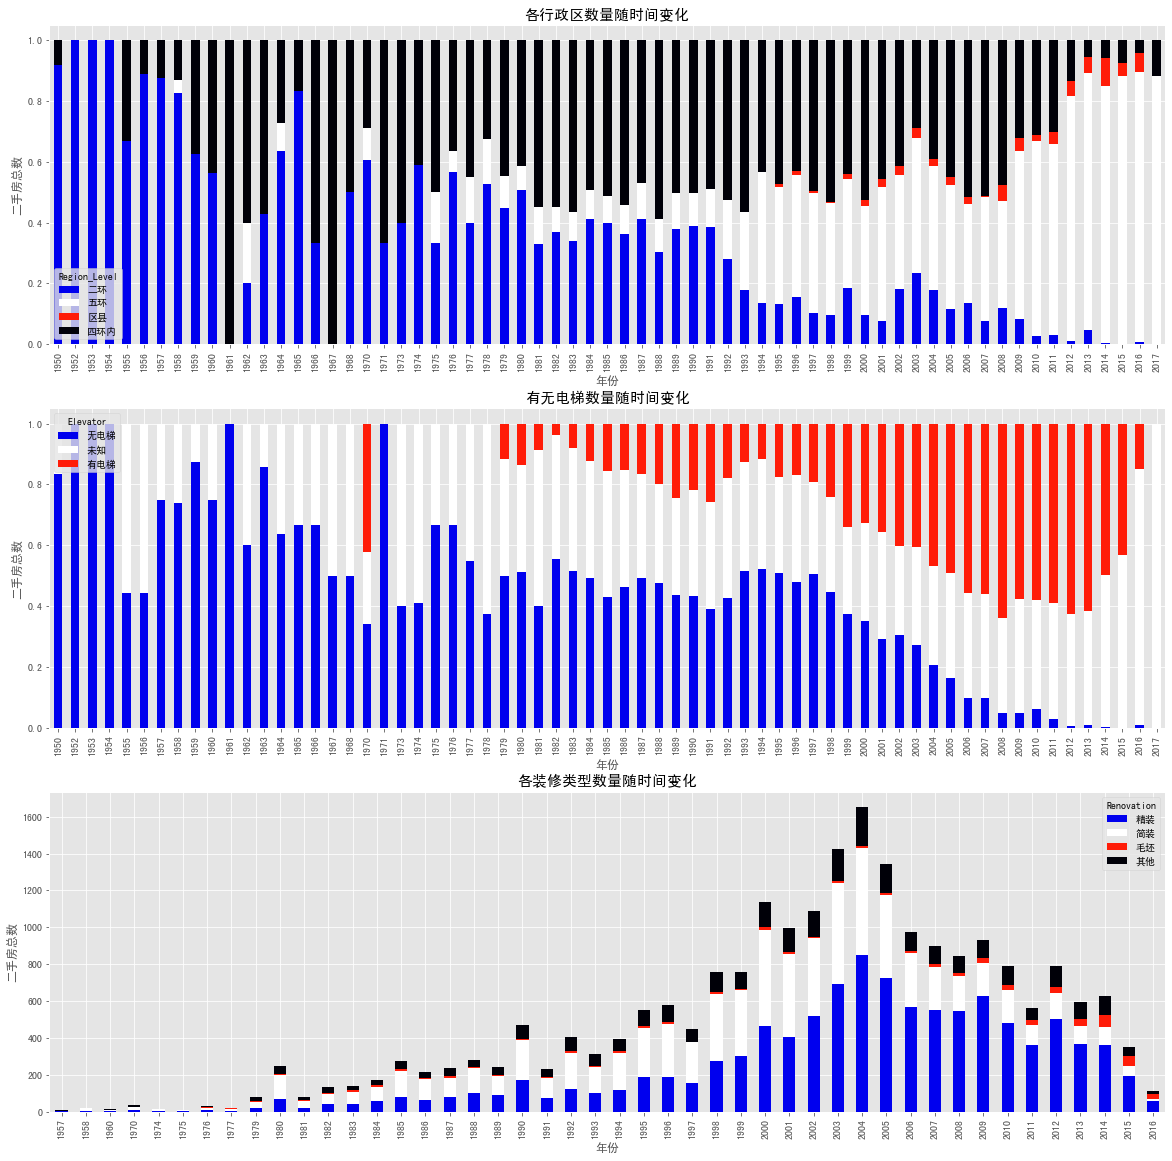

In [68]:
f, axes = plt.subplots(3, 1, figsize=(20, 20))
color = 'flag_r'

# sns.lineplot(x='Year', y='PerPrice', hue='Region', data=df, ax=axes[2], estimator=np.count_nonzero)
# sns.lineplot(x='Year', y='PerPrice', hue='Elevator', data=df, ax=axes[2], estimator=np.count_nonzero)
# sns.countplot(x='Year', hue='Region', data = df, ax=axes[0])
region_pivot.plot.bar(subplots = False, stacked=True, ax = axes[0], colors=sns.color_palette(color))
axes[0].set_title('各行政区数量随时间变化',fontsize=15)
axes[0].set_xlabel('年份')
axes[0].set_ylabel('二手房总数')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


# sns.countplot(x='Year', hue='Elevator', data = df, ax=axes[1], palette=color)
elevator_pivot.plot.bar(subplots = False, stacked=True, ax = axes[1], colors=sns.color_palette(color))
axes[1].set_title('有无电梯数量随时间变化',fontsize=15)
axes[1].set_xlabel('年份')
axes[1].set_ylabel('二手房总数')
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# sns.countplot(x='Year', hue='Renovation', data = df, ax=axes[2])
renovation_pivot.plot.bar(subplots=False, stacked=True, ax=axes[2], color=sns.color_palette(color))
axes[2].set_title('各装修类型数量随时间变化',fontsize=15)
axes[2].set_xlabel('年份')
axes[2].set_ylabel('二手房总数')
# axes[2].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

plt.show()
f.savefig('chart/Year.png', bbox_inches='tight')